In [0]:
from google.colab import drive
import os
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Data pre-process

**Download the dataset and unzip**

In [0]:
!wget http://cnrpark.it/dataset/CNR-EXT-Patches-150x150.zip
!unzip ./*.zip

Streaming output truncated to the last 5000 lines.
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_08.06_C08_214.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_10.36_C08_325.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_16.36_C08_291.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_10.06_C08_283.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_08.36_C08_317.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_15.06_C08_321.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_11.36_C08_255.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_09.36_C08_292.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_11.36_C08_327.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_16.06_C08_324.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera8/O_2015-12-19_10.06_C08_285.jpg  
  inflating: PATCHES/OVERCAST/2015-12-19/camera

**Detail of dataset**

In [0]:
num_train = sum(1 for line in open('LABELS/train.txt'))
num_test = sum(1 for line in open('LABELS/test.txt'))
num_val = sum(1 for line in open('LABELS/val.txt'))
print('num_train: %d\nnum_test: %d\nnum_val: %d\n'%
      (num_train, num_test, num_val))

total = num_train + num_test + num_val
#print(num_test/total,num_train/total, num_val/total)

num_sunny = sum(1 for line in open('LABELS/sunny.txt'))
num_rainy = sum(1 for line in open('LABELS/rainy.txt'))
num_overcast = sum(1 for line in open('LABELS/overcast.txt'))
print('num_sunny: %d\nnum_rainy: %d\nnum_overcast: %d\n'%
      (num_sunny, num_rainy, num_overcast))
#total = num_train + num_test + num_val
#print(num_sunny * 0.65, num_rainy * 0.65, num_overcast * 0.65)
print('num_total: %d'%total)

num_train: 94493
num_test: 31825
num_val: 18647

num_sunny: 63178
num_rainy: 37544
num_overcast: 44243

num_total: 144965


In [0]:
# create Cycle GAN dataset
import os
import shutil

#root_path = 'D:/Download/'
root_path = './' # Source path
save_dir = root_path + 'cyc_dataset1/' # Output path


f_n = root_path + 'LABELS/'
img_path = root_path + 'PATCHES/'
ta = f_n + 'sunny.txt'
tb = f_n + 'overcast.txt'
tc = f_n + 'rainy.txt'

def get_data_number():
    try:
        choice = input('What do you want to do?\n1: input numbel\nfull: full dataset\nelse: Preset\n')
        if choice == '1':
            check = True
            while check:
                n_train = int(input('The number of train: '))
                n_test = int(input('The number of test: '))
                n_val = int(input('The number of val: '))
                check = False
                #if n_train + n_test + n_val < sum(1 for line in open('LABELS/sunny.txt'))
        if choice == 'full':
            num_sunny = sum(1 for line in open(f_n + 'sunny.txt'))
   
            n_val = 5000
            n_test = 15000
            n_train = num_sunny
        else: #if choice == 's':
            n_train = 3000
            n_test = 1000
            n_val = 1000
        
    except:
        print('ERROR INPUT!')
    
    return n_train, n_test, n_val

def create_save_path(save_dir):
    if not os.path.exists(save_dir + 'trainA'):
        os.makedirs(save_dir + 'trainA')
    if not os.path.exists(save_dir + 'testA'):
        os.makedirs(save_dir + 'testA')
    if not os.path.exists(save_dir + 'valA'):
        os.makedirs(save_dir + 'valA')
    if not os.path.exists(save_dir + 'trainB'):
        os.makedirs(save_dir + 'trainB')
    if not os.path.exists(save_dir + 'testB'):
        os.makedirs(save_dir + 'testB')
    if not os.path.exists(save_dir + 'valB'):
        os.makedirs(save_dir + 'valB')

def copy_dataset(domain, file_name, status, n_train, n_test, n_val):
    #data_type = "train%s" % domain if not is_testing else "test%s" % domain
    f = open(file_name, "r")
    count = 0
    check = True
    status_num = 1
    if status == 'free':
        status_num = 0

    while True:
        line = f.readline()
        if not line or not check:
            print('\nfinish!', file_name)
            break
        
        li = str(line)
        sname = li.split(' ')[0].split('/')[-1]
        source_n = li.split(' ')[0]
        source_n = img_path + source_n
        bl = int(li.split(' ')[1])
        if bl == status_num:
            count += 1
            if count < n_val:
                sname = save_dir + 'val' + domain + '/' + sname
            elif count < n_val + n_test:
                sname = save_dir + 'test' + domain + '/' + sname
            elif count < n_train + n_test + n_val:
                sname = save_dir + 'train' + domain + '/' + sname
            else:
                check = False
            shutil.copy(source_n, sname)
            print('\r',str(count),' ',source_n,end='')
    f.close()

# main part
if __name__ == '__main__':
    create_save_path(save_dir)
    n_train, n_test, n_val = get_data_number()
    num_sunny = sum(1 for line in open(f_n + 'sunny.txt'))

    status_a = 'busy'
    copy_dataset('A', ta, status_a, n_train, n_test, n_val)
    copy_dataset('B', tb, status_a, n_train, n_test, n_val)
    copy_dataset('B', tc, status_a, n_train, n_test, n_val)

    status_a = 'free'
    copy_dataset('A', ta, status_a, n_train, n_test, n_val)
    copy_dataset('B', tb, status_a, n_train, n_test, n_val)
    copy_dataset('B', tc, status_a, n_train, n_test, n_val)

    print('Success create dataset!\nThe location is: %s\n'%save_dir)

What do you want to do?
1: input numbel
full: full dataset
else: Automatic
full
 37513   ./PATCHES/SUNNY/2015-11-27/camera9/S_2015-11-27_11.17_C09_291.jpg
finish! ./LABELS/sunny.txt
 23176   ./PATCHES/OVERCAST/2015-11-25/camera8/O_2015-11-25_11.02_C08_214.jpg
finish! ./LABELS/overcast.txt
 18618   ./PATCHES/RAINY/2016-01-08/camera3/R_2016-01-08_14.19_C03_225.jpg
finish! ./LABELS/rainy.txt
 25665   ./PATCHES/SUNNY/2015-11-22/camera7/S_2015-11-22_15.19_C07_310.jpg
finish! ./LABELS/sunny.txt
 21067   ./PATCHES/OVERCAST/2015-12-03/camera5/O_2015-12-03_09.48_C05_276.jpg
finish! ./LABELS/overcast.txt
 18926   ./PATCHES/RAINY/2016-01-09/camera8/R_2016-01-09_12.13_C08_330.jpg
finish! ./LABELS/rainy.txt
Success create dataset!
The location is: ./cyc_dataset1/



In [0]:
# Cut and paste the cycle gan dataset
import time
st_time = time.time()
!mv ./cyc_data_set_busy1 /content/gdrive/a/FYP
print('Finish time: %s'%str(time.time()-st_time))

Finish time: 1295.9529631137848


#Full ver_fin.


Epoch: 15 / 100
Epoch: 15 Batch: 0>Saved: /content/gdrive/FYP/workGanOutput/python/t32/gen_model/g_model_AB_15_0.h5 and /content/gdrive/FYP/workGanOutput/python/t32/gen_model/g_model_BA_15_0.h5


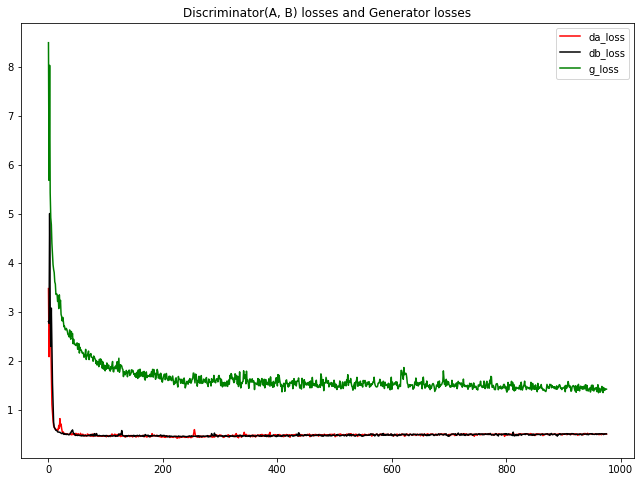

<Figure size 432x288 with 0 Axes>


time: 64 mins 13 s g_loss: [7.42241096496582, 0.9893660545349121, 0.9616365432739258, 0.15474236011505127, 0.14791826903820038, 0.1336330622434616, 0.1380116194486618] 


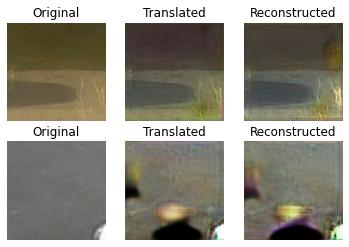

Epoch: 15 Batch: 30
time: 66 mins 9 s g_loss: [7.495621681213379, 0.9612852334976196, 0.943199872970581, 0.17985878884792328, 0.13184840977191925, 0.15863290429115295, 0.11626316606998444] 


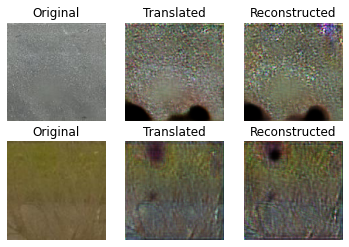

Epoch: 15 Batch: 60
time: 68 mins 5 s g_loss: [6.98790979385376, 0.9389593601226807, 1.0068979263305664, 0.14170020818710327, 0.13436660170555115, 0.1286635845899582, 0.12482354789972305] 


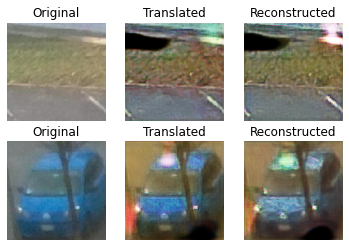

Epoch: 15 Batch: 64
Epoch: 16 / 100
Epoch: 16 Batch: 0
time: 68 mins 25 s g_loss: [7.475407123565674, 0.9593397378921509, 0.9679611921310425, 0.16083350777626038, 0.1449844390153885, 0.1408689320087433, 0.13578958809375763] 


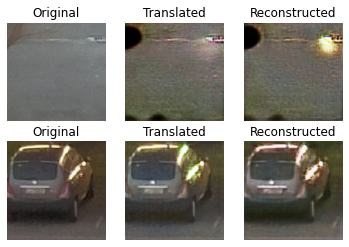

Epoch: 16 Batch: 30
time: 70 mins 21 s g_loss: [7.251404762268066, 1.0564771890640259, 0.9941154718399048, 0.1369706392288208, 0.15047627687454224, 0.1229800283908844, 0.13550251722335815] 


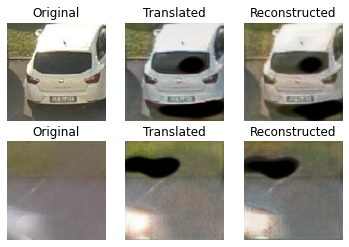

Epoch: 16 Batch: 36

In [0]:
import numpy as np
import scipy
import sys
import os
import cv2
import time

import matplotlib.pyplot as plt
import tensorflow_addons as tfa

exec('from __future__ import print_function, division')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam

from glob import glob
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import img_to_array

# Source path
root_d = './cyc_dataset1/'
#root_d = '/content/gdrive/FYP/5000data/'

# Output path
save_dir = '/content/gdrive/FYP/workGanOutput/python/t'

# Image Size
wide = 128
height = 128
channel = 3
img_shape = (wide, height, channel)

# Number of filters in the first layer of G and D
gf = 32 #int(wide / 4)
df = 64 #int(wide / 2)

re_size = (wide, height)
patch = int(128 / 2**4 * (wide / 128.0))

def conv2d(layer_input, filters, f_size=4, normalization=True):
    """Discriminator layer"""
    d = layers.Conv2D(filters, kernel_size=f_size,
                strides=2, padding='same')(layer_input)
    d = layers.LeakyReLU(alpha=0.2)(d)

    if normalization:
        d = tfa.layers.InstanceNormalization()(d)
    return d

def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    """Layers used during upsampling"""
    u = layers.UpSampling2D(size=2)(layer_input)
    u = layers.Conv2D(filters, kernel_size=f_size, strides=1,
                padding='same', activation='relu')(u)
    if dropout_rate:
        u = layers.Dropout(dropout_rate)(u)
    u = tfa.layers.InstanceNormalization()(u)
    u = layers.Concatenate()([u, skip_input])
    return u

def build_discriminator(lay):
    if lay == '3':
        img = layers.Input(shape=img_shape)
        d1 = conv2d(img, df, normalization=False)
        d2 = conv2d(d1, df * 2)
        d3 = conv2d(d2, df * 4)

        validity = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d3)
    else:
        img = layers.Input(shape=img_shape)
        d1 = conv2d(img, df, normalization=False)
        d2 = conv2d(d1, df * 2)
        d3 = conv2d(d2, df * 4)
        d4 = conv2d(d3, df * 8)

        validity = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    return keras.models.Model(img, validity)

def build_generator(lay):
    """U-Net Generator"""
    # Image input
    d0 = keras.Input(shape=img_shape)
    if lay == '3':   
        # Downsampling)
        d1 = conv2d(d0, gf)
        d2 = conv2d(d1, gf * 2)
        d3 = conv2d(d2, gf * 4)
    
        # Upsampling
        u1 = deconv2d(d3, d2, gf * 2)
        u2 = deconv2d(u1, d1, gf)
    
        u4 = layers.UpSampling2D(size=2)(u2)
        output_img = layers.Conv2D(3, kernel_size=4,
                                  strides=1, padding='same', activation='tanh')(u4)
    
    else:
        # Downsampling
        d1 = conv2d(d0, gf)
        d2 = conv2d(d1, gf * 2)
        d3 = conv2d(d2, gf * 4)
        d4 = conv2d(d3, gf * 8)
        # Upsampling
        u1 = deconv2d(d4, d3, gf * 4)
        u2 = deconv2d(u1, d2, gf * 2)
        u3 = deconv2d(u2, d1, gf)
    
        u4 = layers.UpSampling2D(size=2)(u3)
        output_img = layers.Conv2D(3, kernel_size=4,
                                  strides=1, padding='same', activation='tanh')(u4)
    return keras.models.Model(d0, output_img)


# save the generator models to file
def save_models(epoch, batch_i, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    model_path = save_dir + 'gen_model/'
    filename1 = model_path + 'g_model_AB_%d_%d.h5' % (epoch, batch_i)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = model_path + 'g_model_BA_%d_%d.h5' % (epoch, batch_i)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

def average(lst): 
    return sum(lst) / len(lst) 
    
# plot the losses during training
def plot_losses(losses):
    da_loss = []
    db_loss = []
    gc = []
    for i in range(len(losses)):
        da_loss.append(losses[i][0].mean())
        db_loss.append(losses[i][1].mean())
        gc.append(average(losses[i][3]))

    epochs = range(len(da_loss))
    plt.plot(epochs, da_loss, 'r', label='da_loss')
    plt.plot(epochs, db_loss, 'k', label='db_loss')
    plt.plot(epochs, gc, 'g', label='g_loss')
    plt.title('Discriminator(A, B) losses and Generator losses')
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(11,8)
    plt.figure()
    plt.show()

def load_batch(batch_size=1, is_testing = False, b_size = re_size):
    data_type = "train" if not is_testing else "val"
    path_A = glob(root_d + '%sA/*' % data_type)
    path_B = glob(root_d + '%sB/*' % data_type)
    
    n_batches = int(min(len(path_A), len(path_B)) / batch_size)
    total_samples = n_batches * batch_size

    path_A = np.random.choice(path_A, total_samples, replace=False)
    path_B = np.random.choice(path_B, total_samples, replace=False)

    for i in range(n_batches-1):
        batch_A = path_A[i*batch_size:(i+1)*batch_size]
        batch_B = path_B[i*batch_size:(i+1)*batch_size]
        imgs_A, imgs_B = [], []
        for img_A, img_B in zip(batch_A, batch_B):
            img_A = load_img(img_A, target_size = b_size)
            img_B = load_img(img_B, target_size = b_size)
            img_A = img_to_array(img_A)
            img_B = img_to_array(img_B)
            if not is_testing and np.random.random() > 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        yield imgs_A, imgs_B

def load_data(domain, batch_size=1, is_testing=False, b_size = re_size):
    data_type = "train%s" % domain if not is_testing else "test%s" % domain
    path = glob(root_d + '%s/*' % data_type)

    batch_images = np.random.choice(path, size = batch_size)

    imgs = []
    for img_path in batch_images:
        img = load_img(img_path, target_size = b_size)
        img = img_to_array(img)
        if not is_testing and np.random.random() > 0.5:
            img = np.fliplr(img)
        imgs.append(img)
        
    imgs = np.array(imgs)/127.5 - 1.
    return imgs

def sample_images(epoch, batch_i, g_AB, g_BA):
    r, c = 2, 3

    imgs_A = load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = g_BA.predict(fake_B)
    reconstr_B = g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(save_dir + "%d_%d.png" % (epoch, batch_i))
    plt.show()
    #plt.close(fig)
    return g_AB, g_BA


def save_image(epoch, batch_i, g_AB, g_BA):
    imgs_A = load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = g_BA.predict(fake_B)
    reconstr_B = g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    r, c = 2, 3
    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(save_dir + "%d_%d.png" % (epoch, batch_i))
    plt.show()
    #plt.close(fig)
    
    cnt = 0
    for i in [1, 2, 4, 5]:
        fig, axs = plt.subplots()
        img = gen_imgs[i]
        axs.imshow(img)
        save_path = save_dir + "generate_img/generate_img_%d_%d_%d.png" % (epoch, batch_i, cnt)
        cnt += 1
        fig.savefig(save_path)
        plt.close(fig)
        
    return g_AB, g_BA

def gan_init(lay):
    g_AB = build_generator(lay)
    g_BA = build_generator(lay)
    d_A = build_discriminator(lay)
    d_B = build_discriminator(lay)
    optimizer1 =  keras.optimizers.Adam(0.0002, 0.5)
    d_A.compile(loss='mse',
                optimizer=optimizer1,
                metrics=['accuracy'])
    d_B.compile(loss='mse',
                optimizer=optimizer1,
                metrics=['accuracy'])
    img_A = layers.Input(shape=img_shape)
    img_B = layers.Input(shape=img_shape)

    fake_B = g_AB(img_A)
    fake_A = g_BA(img_B)
    # Translate images back to original domain
    reconstr_A = g_BA(fake_B)
    reconstr_B = g_AB(fake_A)
    # Identity mapping of images
    img_A_id = g_BA(img_A)
    img_B_id = g_AB(img_B)

    d_A.trainable = False
    d_B.trainable = False

    valid_A = d_A(fake_A)
    valid_B = d_B(fake_B)

    lambda_cycle = 10.0
    lambda_id = 0.9 * lambda_cycle  
    combined = keras.models.Model(inputs=[img_A, img_B],
                                  outputs=[valid_A, valid_B,
                                          reconstr_A, reconstr_B,
                                          img_A_id, img_B_id])
    
    com_optimizer = keras.optimizers.Adam(0.0002, 0.5)
    combined.compile(loss=['mse', 'mse',
                                'mae', 'mae',
                                'mae', 'mae'],
                    loss_weights=[1, 1,
                                  lambda_cycle, lambda_cycle,
                                  lambda_id, lambda_id],
                    optimizer = com_optimizer)
    return combined, g_AB, g_BA, d_A, d_B

def train(epochs, batch_size=1, sample_interval=50, lay = '4'):
    # Adversarial loss ground truths
    if lay == '3':
        disc_patch = (patch*2, patch*2, 1)
        batch_size = 8
    else:
        disc_patch = (patch, patch, 1)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir + 'generate_img/')

    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)
    combined = ''
    losses = []
    combined, g_AB, g_BA, d_A, d_B = gan_init(lay)

    print('\nGenerator detail:\n')
    g_AB.summary()
    print('\n\n---------------------------------\n\n')
    print('\nDiscriminator detail:\n')
    d_A.summary()

    print('\n-----------Start!----------')
    st_time = time.time()
    for epoch in range(epochs):
        if epoch % 5 == 0 and epoch != 0:
            clear_output(wait=True)
        print('\nEpoch: %d / %d' % (epoch, epochs))
        for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):
            # ----------------------
            #  Train Discriminators
            # ----------------------
            print('\rEpoch: %d Batch: %d' % (epoch, batch_i), end = '')
            # Translate images to opposite domain
            fake_B = g_AB.predict(imgs_A)
            fake_A = g_BA.predict(imgs_B)
            
            # Train the discriminators (original images = real / translated = Fake)
            dA_loss_real = d_A.train_on_batch(imgs_A, valid)
            dA_loss_fake = d_A.train_on_batch(fake_A, fake)
            dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
            dB_loss_real = d_B.train_on_batch(imgs_B, valid)
            dB_loss_fake = d_B.train_on_batch(fake_B, fake)
            dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

            # Total discriminator loss
            d_loss = 0.5 * np.add(dA_loss, dB_loss)

            # ------------------
            #  Train Generators
            # ------------------
            
            # Train the generators
            g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                              [valid, valid,
                                              imgs_A, imgs_B,
                                              imgs_A, imgs_B])
            seconds = time.time() - st_time
            losses.append((dA_loss, dB_loss, d_loss, g_loss))
            if epoch != 0 and epoch % 5 == 0 and batch_i == 0:
                save_models(epoch, batch_i, g_AB, g_BA)
                plot_losses(losses)
            # If at save interval => plot the generated image samples
            if batch_i % sample_interval == 0:
                print('\ntime: %d mins %d s g_loss: %s ' % (int(seconds/60.0), int(seconds)%60, str(g_loss)))
                if epoch < 5: #30
                    g_AB, g_BA = sample_images(epoch, batch_i, g_AB, g_BA)
                else:
                    g_AB, g_BA = save_image(epoch, batch_i, g_AB, g_BA)


                
def create_output_path():
    global save_dir
    check = True
    num = 0
    while check:
        save_d = save_dir + str(num) + '/'
        if os.path.exists(save_d) == True:
            num += 1
        else:
            save_dir = save_d
            check = False
            os.makedirs(save_dir + 'generate_img/')
            os.makedirs(save_dir + 'gen_model/')
    print('Save location is: %s\n'%save_dir)

def main(argv):
    try:
        if len(argv) != 1:
            print('Unable Input!')
            sys.exit(0)

        create_output_path()
        train(epochs=100, batch_size=64, sample_interval=30, lay=argv)
    except:
        print('Please input INPUT, the formular is:\npython final_ver_cyclegan.py 3')
        sys.exit(1)
        
if __name__ == "__main__":
    main('4')

**One plot losses example**

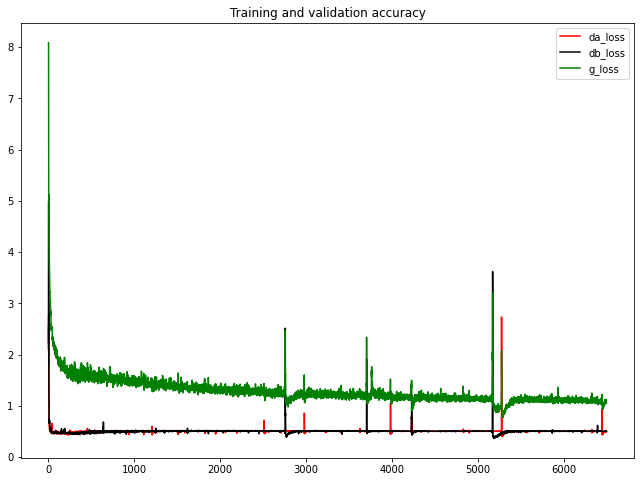

<Figure size 432x288 with 0 Axes>

In [0]:
# plot the loss and accuracy of the model over the training and validation data during training:
import matplotlib.pyplot as plt
%matplotlib inline
arr = losses

da_loss = []
db_loss = []
gc = []

def Average(lst): 
    return sum(lst) / len(lst) 

for i in range(len(arr)):
    da_loss.append(arr[i][0].mean())
    db_loss.append(arr[i][1].mean())
    gc.append(Average(arr[i][3]))
    #gc.append(arr[i][2])
#val_acc = losses

epochs = range(len(da_loss))
#print(epochs, range(len(gc)))
plt.plot(epochs, da_loss, 'r', label='da_loss')
plt.plot(epochs, db_loss, 'k', label='db_loss')
plt.plot(epochs, gc, 'g', label='g_loss')
plt.title('Training and validation accuracy')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(11,8)
plt.figure()
plt.show()

# Step by Step

### An example with command

In [0]:
!python /content/gdrive/a/FYP/Cycle_GAN.py 4

2020-05-05 07:13:41.411342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.
Save location is: /content/gdrive/FYP/workGanOutput/python/test10/

2020-05-05 07:13:42.897699: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-05 07:13:42.919865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-05 07:13:42.920458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-05-05 07:13:42.920515: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened

###**Input**

In [0]:
# Dataset source local location
#root_d = '/content/gdrive/FYP/appleorange/'
#root_d = '/content/gdrive/FYP/car_sunnyArainy_dataset/'
root_d = '/content/gdrive/FYP/5000data/'
#root_d = './oot/'

# Output source location
#save_dir = '/content/gdrive/FYP/workGanOutput/car_sunnyArainy_dataset/128x128_batchsize64_t2/'
save_dir = '/content/gdrive/FYP/workGanOutput/5000data_dataset/256x256_batchsize64_t4_24/t1/'

# Image size for input
wide = 128
height = 128
channel = 3

# Global variables
img_shape = (wide, height, channel)
gf = 32 #int(wide / 4) 
df = 64 #int(wide / 2) 
re_size = (wide, height)
patch = int(128 / 2**4 * (wide / 128.0)) #* 4)
print(patch)

8


### 4 layers CYCLE GAN

In [0]:
import numpy as np
import scipy
import sys
import os
import cv2
import time

import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from __future__ import print_function, division

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from glob import glob
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import img_to_array

def conv2d(layer_input, filters, f_size=4, normalization=True):
  """Discriminator layer"""
  d = layers.Conv2D(filters, kernel_size=f_size,
              strides=2, padding='same')(layer_input)
  d = layers.LeakyReLU(alpha=0.2)(d)

  if normalization:
      d = tfa.layers.InstanceNormalization()(d)
  return d

def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
      """Layers used during upsampling"""
      u = layers.UpSampling2D(size=2)(layer_input)
      u = layers.Conv2D(filters, kernel_size=f_size, strides=1,
                  padding='same', activation='relu')(u)
      if dropout_rate:
          u = layers.Dropout(dropout_rate)(u)
      u = tfa.layers.InstanceNormalization()(u)
      u = layers.Concatenate()([u, skip_input])
      return u

def build_discriminator():
      img = layers.Input(shape=img_shape)
      d1 = conv2d(img, df, normalization=False)
      d2 = conv2d(d1, df * 2)
      d3 = conv2d(d2, df * 4)
      d4 = conv2d(d3, df * 8)

      validity = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
      return keras.models.Model(img, validity)

def build_generator():
        """U-Net Generator"""
        # Image input
        
        d0 = keras.Input(shape=img_shape)
        # Downsampling
        d1 = conv2d(d0, gf)
        d2 = conv2d(d1, gf * 2)
        d3 = conv2d(d2, gf * 4)
        d4 = conv2d(d3, gf * 8)
        # Upsampling
        u1 = deconv2d(d4, d3, gf * 4)
        u2 = deconv2d(u1, d2, gf * 2)
        u3 = deconv2d(u2, d1, gf)

        u4 = layers.UpSampling2D(size=2)(u3)
        output_img = layers.Conv2D(3, kernel_size=4,
                                  strides=1, padding='same', activation='tanh')(u4)
        return keras.models.Model(d0, output_img)

def load_batch(batch_size=1, is_testing = False, b_size = re_size):
    data_type = "train" if not is_testing else "val"
    path_A = glob(root_d + '%sA/*' % data_type)
    path_B = glob(root_d + '%sB/*' % data_type)
    
    n_batches = int(min(len(path_A), len(path_B)) / batch_size)
    total_samples = n_batches * batch_size

    path_A = np.random.choice(path_A, total_samples, replace=False)
    path_B = np.random.choice(path_B, total_samples, replace=False)

    for i in range(n_batches-1):
        batch_A = path_A[i*batch_size:(i+1)*batch_size]
        batch_B = path_B[i*batch_size:(i+1)*batch_size]
        imgs_A, imgs_B = [], []
        for img_A, img_B in zip(batch_A, batch_B):
            img_A = load_img(img_A, target_size = b_size)
            img_B = load_img(img_B, target_size = b_size)
            img_A = img_to_array(img_A)
            img_B = img_to_array(img_B)
            if not is_testing and np.random.random() > 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        yield imgs_A, imgs_B

def load_data(domain, batch_size=1, is_testing=False, b_size = re_size):
    data_type = "train%s" % domain if not is_testing else "test%s" % domain
    path = glob(root_d + '%s/*' % data_type)

    batch_images = np.random.choice(path, size = batch_size)

    imgs = []
    for img_path in batch_images:
        img = load_img(img_path, target_size = b_size)
        img = img_to_array(img)
        if not is_testing and np.random.random() > 0.5:
            img = np.fliplr(img)
        imgs.append(img)
        
    imgs = np.array(imgs)/127.5 - 1.
    return imgs

def sample_images(epoch, batch_i, g_AB, g_BA):
    r, c = 2, 3

    imgs_A = load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = g_BA.predict(fake_B)
    reconstr_B = g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(save_dir + "%d_%d.png" % (epoch, batch_i))
    plt.show()
    return g_AB, g_BA


def save_image(epoch, batch_i, g_AB, g_BA):
    imgs_A = load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = g_BA.predict(fake_B)
    reconstr_B = g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    cnt = 0
    for i in [1, 2, 4, 5]:
        fig, axs = plt.subplots()
        cnt += 1
        img = gen_imgs[i]
        axs.imshow(img)
        save_path = save_dir + "generate_img/generate_img_%d_%d_%d.png" % (epoch, batch_i, cnt)
        fig.savefig(save_path)
        #plt.close(fig)
    return g_AB, g_BA

def gan_compile():
    g_AB = build_generator()
    g_BA = build_generator()
    d_A = build_discriminator()
    d_B = build_discriminator()
    optimizer1 =  keras.optimizers.Adam(0.0002, 0.5)
    d_A.compile(loss='mse',
                optimizer=optimizer1,
                metrics=['accuracy'])
    d_B.compile(loss='mse',
                optimizer=optimizer1,
                metrics=['accuracy'])
    img_A = layers.Input(shape=img_shape)
    img_B = layers.Input(shape=img_shape)

    fake_B = g_AB(img_A)
    fake_A = g_BA(img_B)
    # Translate images back to original domain
    reconstr_A = g_BA(fake_B)
    reconstr_B = g_AB(fake_A)
    # Identity mapping of images
    img_A_id = g_BA(img_A)
    img_B_id = g_AB(img_B)

    d_A.trainable = False
    d_B.trainable = False

    valid_A = d_A(fake_A)
    valid_B = d_B(fake_B)

    lambda_cycle = 10.0
    lambda_id = 0.9 * lambda_cycle  
    combined = keras.models.Model(inputs=[img_A, img_B],
                                  outputs=[valid_A, valid_B,
                                          reconstr_A, reconstr_B,
                                          img_A_id, img_B_id])
    
    com_optimizer = keras.optimizers.Adam(0.0002, 0.5)
    combined.compile(loss=['mse', 'mse',
                                'mae', 'mae',
                                'mae', 'mae'],
                    loss_weights=[1, 1,
                                  lambda_cycle, lambda_cycle,
                                  lambda_id, lambda_id],
                    optimizer = com_optimizer)
    return combined, g_AB, g_BA, d_A, d_B

def train(epochs, batch_size=1, sample_interval=50):
    # Adversarial loss ground truths
    #disc_patch = (int(patch*2), int(patch*2), 1)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        os.makedirs(save_dir + 'generate_img/')

    disc_patch = (patch, patch, 1)
    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)
    combined = ''
    combined, g_AB, g_BA, d_A, d_B = gan_compile()

    g_AB.summary()
    print('\n\n---------------------------------\n\n')
    d_A.summary()
    
    print('\n---Start!---\n')
    st_time = time.time()
    for epoch in range(epochs):
        if epoch % 2 == 1:
            clear_output(wait=True)
        print('Epoch: %d / %d' % (epoch, epochs))
        for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):
            # ----------------------
            #  Train Discriminators
            # ----------------------
            print('\rEpoch: %d Batch: %d' % (epoch, batch_i), end = '')
            # Translate images to opposite domain
            fake_B = g_AB.predict(imgs_A)
            fake_A = g_BA.predict(imgs_B)
            
            # Train the discriminators (original images = real / translated = Fake)
            dA_loss_real = d_A.train_on_batch(imgs_A, valid)
            dA_loss_fake = d_A.train_on_batch(fake_A, fake)
            dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
            dB_loss_real = d_B.train_on_batch(imgs_B, valid)
            dB_loss_fake = d_B.train_on_batch(fake_B, fake)
            dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

            # Total discriminator loss
            d_loss = 0.5 * np.add(dA_loss, dB_loss)

            # ------------------
            #  Train Generators
            # ------------------
            
            # Train the generators
            g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                              [valid, valid,
                                              imgs_A, imgs_B,
                                              imgs_A, imgs_B])
            seconds = time.time() - st_time
            #print('time: %d mins %d s g_loss: %s ' % (int(seconds/60.0), int(seconds)%60, str(g_loss)))
            # If at save interval => plot the generated image samples
            if batch_i % sample_interval == 0:
                print('\ntime: %d mins %d s g_loss: %s ' % (int(seconds/60.0), int(seconds)%60, str(g_loss)))
                if epoch >30: #30
                    g_AB, g_BA = sample_images(epoch, batch_i, g_AB, g_BA)
                else:
                    g_AB, g_BA = save_image(epoch, batch_i, g_AB, g_BA)

Using TensorFlow backend.


In [0]:
# Main Part
if __name__ == '__main__':
    train(epochs=200, batch_size=64, sample_interval=10)

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 64, 64, 32)   1568        input_37[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_96 (LeakyReLU)      (None, 64, 64, 32)   0           conv2d_156[0][0]                 
__________________________________________________________________________________________________
instance_normalization_120 (Ins (None, 64, 64, 32)   64          leaky_re_lu_96[0][0]             
___________________________________________________________________________________________

KeyboardInterrupt: ignored

# 3 layers cycle GAN

In [0]:
import numpy as np
import scipy
import sys
import os
import cv2
import time

import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from __future__ import print_function, division

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from glob import glob
from IPython.display import clear_output

def conv2d(layer_input, filters, f_size=4, normalization=True):
  """Discriminator layer"""
  d = layers.Conv2D(filters, kernel_size=f_size,
              strides=2, padding='same')(layer_input)
  d = layers.LeakyReLU(alpha=0.2)(d)

  if normalization:
      d = tfa.layers.InstanceNormalization()(d)
  return d

def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
      """Layers used during upsampling"""
      u = layers.UpSampling2D(size=2)(layer_input)
      u = layers.Conv2D(filters, kernel_size=f_size, strides=1,
                  padding='same', activation='relu')(u)
      if dropout_rate:
          u = layers.Dropout(dropout_rate)(u)
      u = tfa.layers.InstanceNormalization()(u)
      u = layers.Concatenate()([u, skip_input])
      return u

def build_discriminator():
      img = layers.Input(shape=img_shape)
      d1 = conv2d(img, df, normalization=False)
      d2 = conv2d(d1, df * 2)
      d3 = conv2d(d2, df * 4)
      #d4 = conv2d(d3, df * 8)

      validity = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d3)#(d4)
      return keras.models.Model(img, validity)

def build_generator():
        """U-Net Generator"""
        # Image input
        
        d0 = keras.Input(shape=img_shape)
        # Downsampling)
        d1 = conv2d(d0, gf)
        d2 = conv2d(d1, gf * 2)
        d3 = conv2d(d2, gf * 4)
        #d4 = conv2d(d3, gf * 8)
        # Upsampling
        u2 = deconv2d(d3, d2, gf * 2)
        u3 = deconv2d(u2, d1, gf)
        '''
        u1 = deconv2d(d4, d3, gf * 4)
        u2 = deconv2d(u1, d2, gf * 2)
        u3 = deconv2d(u2, d1, gf)
        '''

        u4 = layers.UpSampling2D(size=2)(u3)
        output_img = layers.Conv2D(3, kernel_size=4,
                                  strides=1, padding='same', activation='tanh')(u4)
        return keras.models.Model(d0, output_img)

def load_batch(batch_size=1, is_testing = False, b_size = re_size):
    data_type = "train" if not is_testing else "val"
    path_A = glob(root_d + '%sA/*' % data_type)
    path_B = glob(root_d + '%sB/*' % data_type)
    
    n_batches = int(min(len(path_A), len(path_B)) / batch_size)
    total_samples = n_batches * batch_size

    path_A = np.random.choice(path_A, total_samples, replace=False)
    path_B = np.random.choice(path_B, total_samples, replace=False)
    #load_img(path + filename, target_size=size)
    #print(path_A)
    #print(path_B)
    for i in range(n_batches-1):
        #img = sun_Busy[img_path]
        batch_A = path_A[i*batch_size:(i+1)*batch_size]
        batch_B = path_B[i*batch_size:(i+1)*batch_size]
        imgs_A, imgs_B = [], []
        for img_A, img_B in zip(batch_A, batch_B):
            img_A = load_img(img_A, target_size = b_size)
            img_B = load_img(img_B, target_size = b_size)
            img_A = img_to_array(img_A)
            img_B = img_to_array(img_B)
            #print(img_A.shape)
            if not is_testing and np.random.random() > 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)
            #img = scipy.misc.imresize(img, self.img_res)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        yield imgs_A, imgs_B

def load_data(domain, batch_size=1, is_testing=False, b_size = re_size):
    data_type = "train%s" % domain if not is_testing else "test%s" % domain
    path = glob(root_d + '%s/*' % data_type)

    batch_images = np.random.choice(path, size = batch_size)

    imgs = []
    for img_path in batch_images:
        img = load_img(img_path, target_size = b_size)
        img = img_to_array(img)
        if not is_testing and np.random.random() > 0.5:
            img = np.fliplr(img)
        imgs.append(img)
        
    imgs = np.array(imgs)/127.5 - 1.
    return imgs

def sample_images(epoch, batch_i, g_AB, g_BA):
    r, c = 2, 3

    imgs_A = load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = g_BA.predict(fake_B)
    reconstr_B = g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(save_dir + "%d_%d.png" % (epoch, batch_i))
    plt.show()
    return g_AB, g_BA

def save_image(epoch, batch_i, g_AB, g_BA):
    imgs_A = load_data(domain="A", batch_size=1, is_testing=True)
    imgs_B = load_data(domain="B", batch_size=1, is_testing=True)

    # Translate images to the other domain
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)
    # Translate back to original domain
    reconstr_A = g_BA.predict(fake_B)
    reconstr_B = g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    cnt = 0
    for i in [1, 2, 4, 5]:
        fig, axs = plt.subplots()
        cnt += 1
        img = gen_imgs[i]
        axs.imshow(img)
        save_path = save_dir + "generate_img/generate_img_%d_%d_%d.png" % (epoch, batch_i, cnt)
        fig.savefig(save_path)
        #plt.close(fig)
    return g_AB, g_BA

def gan_compile():
    g_AB = build_generator()
    g_BA = build_generator()
    d_A = build_discriminator()
    d_B = build_discriminator()
    optimizer1 =  keras.optimizers.Adam(0.0002, 0.5)
    d_A.compile(loss='mse',
                optimizer=optimizer1,
                metrics=['accuracy'])
    d_B.compile(loss='mse',
                optimizer=optimizer1,
                metrics=['accuracy'])
    img_A = layers.Input(shape=img_shape)
    img_B = layers.Input(shape=img_shape)

    fake_B = g_AB(img_A)
    fake_A = g_BA(img_B)
    # Translate images back to original domain
    reconstr_A = g_BA(fake_B)
    reconstr_B = g_AB(fake_A)
    # Identity mapping of images
    img_A_id = g_BA(img_A)
    img_B_id = g_AB(img_B)

    d_A.trainable = False
    d_B.trainable = False

    valid_A = d_A(fake_A)
    valid_B = d_B(fake_B)

    lambda_cycle = 10.0
    lambda_id = 0.9 * lambda_cycle  
    combined = keras.models.Model(inputs=[img_A, img_B],
                                  outputs=[valid_A, valid_B,
                                          reconstr_A, reconstr_B,
                                          img_A_id, img_B_id])
    
    com_optimizer = keras.optimizers.Adam(0.0002, 0.5)
    combined.compile(loss=['mse', 'mse',
                                'mae', 'mae',
                                'mae', 'mae'],
                    loss_weights=[1, 1,
                                  lambda_cycle, lambda_cycle,
                                  lambda_id, lambda_id],
                    optimizer = com_optimizer)
    return combined, g_AB, g_BA, d_A, d_B

def train(epochs, batch_size=1, sample_interval=50):
    # Adversarial loss ground truths
    disc_patch = (patch*2, patch*2, 1)

    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)
    combined = ''
    combined, g_AB, g_BA, d_A, d_B = gan_compile()
    g_AB.summary()
    print('\n\n---------------------------------\n\n')
    d_A.summary()

    print('\n---Start!---\n')
    st_time = time.time()
    for epoch in range(epochs):
        if epoch % 2 == 1:
            clear_output(wait=True)
        print('Epoch: %d / %d' % (epoch, epochs))
        for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):
            # ----------------------
            #  Train Discriminators
            # ----------------------
            print('Epoch: %d Batch: %d' % (epoch, batch_i))
            print(imgs_A.shape)
            # Translate images to opposite domain
            fake_B = g_AB.predict(imgs_A)
            fake_A = g_BA.predict(imgs_B)
            print('fake success')
            # Train the discriminators (original images = real / translated = Fake)
            dA_loss_real = d_A.train_on_batch(imgs_A, valid)
            dA_loss_fake = d_A.train_on_batch(fake_A, fake)
            dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
            print('da_loss: ', dA_loss)
            dB_loss_real = d_B.train_on_batch(imgs_B, valid)
            dB_loss_fake = d_B.train_on_batch(fake_B, fake)
            dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

            # Total discriminator loss
            d_loss = 0.5 * np.add(dA_loss, dB_loss)
            print('d_loss: ', d_loss)
            # ------------------
            #  Train Generators
            # ------------------

            # Train the generators
            print('imgs_A: %s, imgB: %s\nvalid:%s' % (imgs_A.shape, imgs_B.shape, valid.shape))
            g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                              [valid, valid,
                                              imgs_A, imgs_B,
                                              imgs_A, imgs_B])
            seconds = time.time() - st_time
            print('time: %d mins %d s g_loss: %s ' % (int(seconds/60.0), int(seconds)%60, str(g_loss)))
            # If at save interval => plot the generated image samples
            if batch_i % sample_interval == 0:
                print('\ntime: %d mins %d s g_loss: %s ' % (int(seconds/60.0), int(seconds)%60, str(g_loss)))
                if epoch >30: #30
                    g_AB, g_BA = sample_images(epoch, batch_i, g_AB, g_BA)
                else:
                    g_AB, g_BA = save_image(epoch, batch_i, g_AB, g_BA)

Epoch: 31 / 200
Epoch: 31 Batch: 0
(8, 128, 128, 3)
fake success
da_loss:  [0.10671224 0.88574219]
d_loss:  [0.07781878 0.93664551]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 26 s g_loss: [5.530223369598389, 0.8605433106422424, 0.9158164262771606, 0.10548718273639679, 0.10456734895706177, 0.09168488532304764, 0.09201715141534805] 
Batch_i : 0 and Sample_interval : 10


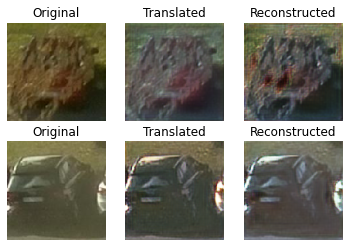

Epoch: 31 Batch: 1
(8, 128, 128, 3)
fake success
da_loss:  [0.06188787 0.94726562]
d_loss:  [0.07404205 0.9128418 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 27 s g_loss: [6.181881904602051, 0.8571168780326843, 0.8684871792793274, 0.14129650592803955, 0.09124539792537689, 0.14571928977966309, 0.09104275703430176] 
Epoch: 31 Batch: 2
(8, 128, 128, 3)
fake success
da_loss:  [0.10966429 0.86425781]
d_loss:  [0.06697403 0.93164062]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 27 s g_loss: [5.917491912841797, 0.8185082077980042, 1.0627470016479492, 0.13251948356628418, 0.10231223702430725, 0.11464013904333115, 0.0729065090417862] 
Epoch: 31 Batch: 3
(8, 128, 128, 3)
fake success
da_loss:  [0.0895753  0.89257812]
d_loss:  [0.06030831 0.94104004]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 27 s g_loss: [6.360396385192871, 0.8855706453323364, 0.9896743297576904, 0.1324815154

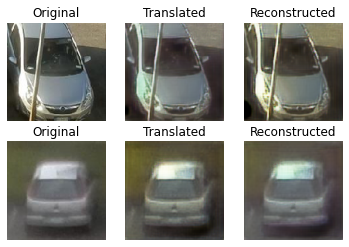

Epoch: 31 Batch: 11
(8, 128, 128, 3)
fake success
da_loss:  [0.08394158 0.91577148]
d_loss:  [0.06225452 0.94396973]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 31 s g_loss: [6.444034099578857, 0.8171282410621643, 0.9017937183380127, 0.11595413088798523, 0.13605301082134247, 0.11945971846580505, 0.12554475665092468] 
Epoch: 31 Batch: 12
(8, 128, 128, 3)
fake success
da_loss:  [0.08194802 0.93408203]
d_loss:  [0.08310952 0.91491699]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 31 s g_loss: [6.549498558044434, 0.8152193427085876, 0.883292555809021, 0.14974847435951233, 0.12015664577484131, 0.1316375583410263, 0.10746632516384125] 
Epoch: 31 Batch: 13
(8, 128, 128, 3)
fake success
da_loss:  [0.05628157 0.97216797]
d_loss:  [0.06282888 0.94921875]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 32 s g_loss: [6.084744930267334, 0.9969450831413269, 0.877671480178833, 0.117737412

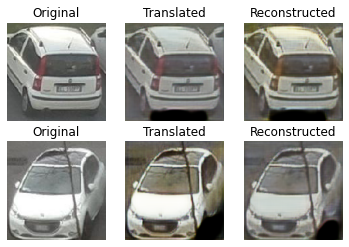

Epoch: 31 Batch: 21
(8, 128, 128, 3)
fake success
da_loss:  [0.09413795 0.88745117]
d_loss:  [0.10131169 0.89160156]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 36 s g_loss: [7.274514198303223, 0.8792740106582642, 1.2901256084442139, 0.139970600605011, 0.14866362512111664, 0.12125100195407867, 0.1252792626619339] 
Epoch: 31 Batch: 22
(8, 128, 128, 3)
fake success
da_loss:  [0.16749542 0.75683594]
d_loss:  [0.1667857  0.78198242]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 36 s g_loss: [6.175732612609863, 0.7258260250091553, 1.0336477756500244, 0.13778463006019592, 0.1078372448682785, 0.12251196801662445, 0.09527026116847992] 
Epoch: 31 Batch: 23
(8, 128, 128, 3)
fake success
da_loss:  [0.08508098 0.92163086]
d_loss:  [0.10794562 0.89709473]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 37 s g_loss: [5.890114784240723, 0.8628901243209839, 0.9787836074829102, 0.1250420212

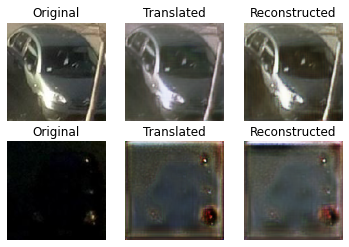

Epoch: 31 Batch: 31
(8, 128, 128, 3)
fake success
da_loss:  [0.12700299 0.8449707 ]
d_loss:  [0.09382105 0.89880371]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 40 s g_loss: [6.6369524002075195, 0.7121847867965698, 0.8841689825057983, 0.12830635905265808, 0.15681958198547363, 0.10625193268060684, 0.13700798153877258] 
Epoch: 31 Batch: 32
(8, 128, 128, 3)
fake success
da_loss:  [0.05243414 0.96630859]
d_loss:  [0.04732376 0.97631836]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 40 s g_loss: [5.76431131362915, 0.9857113361358643, 0.950962245464325, 0.11988290399312973, 0.09600142389535904, 0.10168386250734329, 0.08373770117759705] 
Epoch: 31 Batch: 33
(8, 128, 128, 3)
fake success
da_loss:  [0.11013368 0.88134766]
d_loss:  [0.06427761 0.94018555]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 41 s g_loss: [5.545790195465088, 0.8373452425003052, 0.9241399765014648, 0.1204002

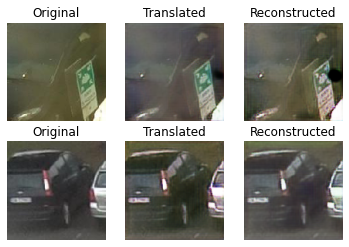

Epoch: 31 Batch: 41
(8, 128, 128, 3)
fake success
da_loss:  [0.10844957 0.90185547]
d_loss:  [0.08624534 0.93237305]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 44 s g_loss: [6.163574695587158, 0.8270231485366821, 0.9425516724586487, 0.13040074706077576, 0.11872972548007965, 0.1111401617527008, 0.10027042031288147] 
Epoch: 31 Batch: 42
(8, 128, 128, 3)
fake success
da_loss:  [0.12520774 0.84472656]
d_loss:  [0.08960189 0.90429688]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 44 s g_loss: [5.664605617523193, 0.852318525314331, 0.9583253264427185, 0.10393828898668289, 0.10951141268014908, 0.09450537711381912, 0.09654627740383148] 
Epoch: 31 Batch: 43
(8, 128, 128, 3)
fake success
da_loss:  [0.16306536 0.82958984]
d_loss:  [0.11119328 0.8927002 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 45 s g_loss: [6.734518527984619, 0.7841156125068665, 0.8341730237007141, 0.16414424

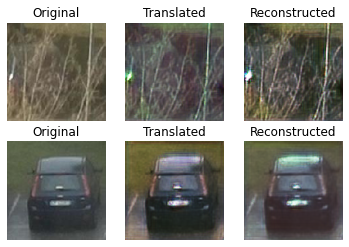

Epoch: 31 Batch: 51
(8, 128, 128, 3)
fake success
da_loss:  [0.09724355 0.91040039]
d_loss:  [0.07376936 0.9329834 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 48 s g_loss: [6.490717887878418, 0.7982470393180847, 0.915174126625061, 0.13925138115882874, 0.11568576842546463, 0.14132371544837952, 0.10622358322143555] 
Epoch: 31 Batch: 52
(8, 128, 128, 3)
fake success
da_loss:  [0.09028923 0.89599609]
d_loss:  [0.07330249 0.93530273]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 49 s g_loss: [5.852856159210205, 0.8743985295295715, 0.8785952925682068, 0.13101467490196228, 0.09549565613269806, 0.12440229952335358, 0.0794597715139389] 
Epoch: 31 Batch: 53
(8, 128, 128, 3)
fake success
da_loss:  [0.08335689 0.93164062]
d_loss:  [0.05922037 0.9597168 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 49 s g_loss: [7.58514404296875, 0.7357649803161621, 0.9944398999214172, 0.157564118

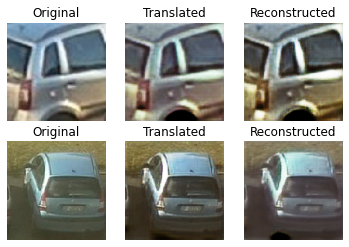

Epoch: 31 Batch: 61
(8, 128, 128, 3)
fake success
da_loss:  [0.1548243  0.79125977]
d_loss:  [0.12586797 0.83361816]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 53 s g_loss: [7.238185882568359, 0.7914033532142639, 0.9212521314620972, 0.12053859233856201, 0.19308440387248993, 0.10442699491977692, 0.16105079650878906] 
Epoch: 31 Batch: 62
(8, 128, 128, 3)
fake success
da_loss:  [0.0598721  0.95947266]
d_loss:  [0.05380145 0.9675293 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 53 s g_loss: [7.144547462463379, 0.9142131805419922, 0.9375741481781006, 0.1505357027053833, 0.158827543258667, 0.1329379379749298, 0.11140958964824677] 
Epoch: 31 Batch: 63
(8, 128, 128, 3)
fake success
da_loss:  [0.06493045 0.93261719]
d_loss:  [0.07691139 0.9140625 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 54 s g_loss: [6.7027716636657715, 0.8671765923500061, 0.9079209566116333, 0.112878918

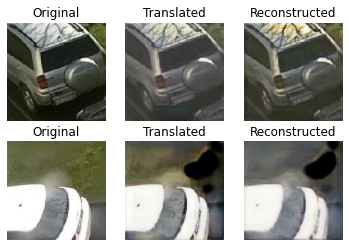

Epoch: 31 Batch: 71
(8, 128, 128, 3)
fake success
da_loss:  [0.06923315 0.92797852]
d_loss:  [0.0590151  0.94360352]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 57 s g_loss: [6.02665901184082, 0.8945788741111755, 0.9457674622535706, 0.12096267193555832, 0.11957338452339172, 0.09835974872112274, 0.09952381998300552] 
Epoch: 31 Batch: 72
(8, 128, 128, 3)
fake success
da_loss:  [0.1128506  0.83862305]
d_loss:  [0.12655108 0.83996582]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 57 s g_loss: [5.911867618560791, 0.7916156053543091, 0.8676816821098328, 0.11358952522277832, 0.13447174429893494, 0.10464590787887573, 0.09223831444978714] 
Epoch: 31 Batch: 73
(8, 128, 128, 3)
fake success
da_loss:  [0.06096764 0.9309082 ]
d_loss:  [0.05865938 0.94702148]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 28 mins 58 s g_loss: [5.963320732116699, 0.9381734728813171, 0.9771812558174133, 0.1157674

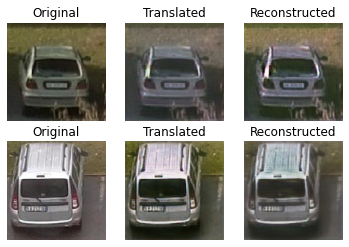

Epoch: 31 Batch: 81
(8, 128, 128, 3)
fake success
da_loss:  [0.14111863 0.84301758]
d_loss:  [0.10173654 0.90405273]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 2 s g_loss: [7.007574081420898, 0.8265936374664307, 0.9184343814849854, 0.12525944411754608, 0.16909003257751465, 0.11435344815254211, 0.14331889152526855] 
Epoch: 31 Batch: 82
(8, 128, 128, 3)
fake success
da_loss:  [0.08206068 0.91772461]
d_loss:  [0.08587053 0.91247559]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 2 s g_loss: [5.964336395263672, 0.8289828300476074, 0.8777389526367188, 0.13159020245075226, 0.1028822660446167, 0.1150764673948288, 0.09746688604354858] 
Epoch: 31 Batch: 83
(8, 128, 128, 3)
fake success
da_loss:  [0.09347207 0.90405273]
d_loss:  [0.07202909 0.93481445]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 2 s g_loss: [6.191171646118164, 0.7370491027832031, 0.8820401430130005, 0.11435571312

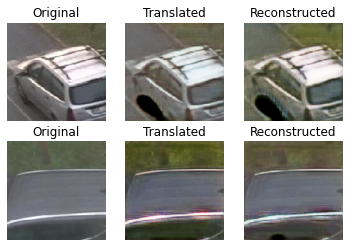

Epoch: 31 Batch: 91
(8, 128, 128, 3)
fake success
da_loss:  [0.05947362 0.94677734]
d_loss:  [0.12535012 0.82849121]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 6 s g_loss: [6.002674579620361, 0.9730037450790405, 0.7585117816925049, 0.12444833666086197, 0.118435338139534, 0.10071607679128647, 0.10398641228675842] 
Epoch: 31 Batch: 92
(8, 128, 128, 3)
fake success
da_loss:  [0.09019089 0.88623047]
d_loss:  [0.14535969 0.79919434]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 6 s g_loss: [5.8298821449279785, 0.7985215187072754, 0.7370157837867737, 0.12050925195217133, 0.10392626374959946, 0.11627879738807678, 0.11149781942367554] 
Epoch: 31 Batch: 93
(8, 128, 128, 3)
fake success
da_loss:  [0.092288   0.90844727]
d_loss:  [0.09874659 0.89892578]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 7 s g_loss: [6.184079170227051, 0.8202357888221741, 0.801945686340332, 0.15489774942

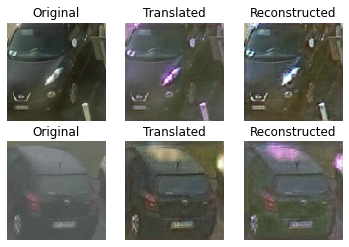

Epoch: 31 Batch: 101
(8, 128, 128, 3)
fake success
da_loss:  [0.06408937 0.94628906]
d_loss:  [0.05030143 0.97009277]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 10 s g_loss: [6.8713154792785645, 0.8284872770309448, 1.0657703876495361, 0.13884194195270538, 0.1398332417011261, 0.11973936855792999, 0.1236279085278511] 
Epoch: 31 Batch: 102
(8, 128, 128, 3)
fake success
da_loss:  [0.09860054 0.88867188]
d_loss:  [0.07985016 0.92602539]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 10 s g_loss: [5.412954807281494, 0.8077998161315918, 0.8692801594734192, 0.10112573951482773, 0.10633693635463715, 0.0904054194688797, 0.0941777229309082] 
Epoch: 31 Batch: 103
(8, 128, 128, 3)
fake success
da_loss:  [0.06076456 0.95678711]
d_loss:  [0.05278564 0.96496582]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 11 s g_loss: [5.591270923614502, 0.9310869574546814, 0.8941085338592529, 0.104945

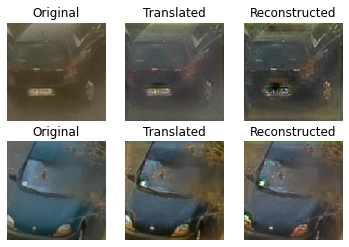

Epoch: 31 Batch: 111
(8, 128, 128, 3)
fake success
da_loss:  [0.06365661 0.95654297]
d_loss:  [0.05762407 0.96191406]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 14 s g_loss: [5.726841926574707, 0.7907467484474182, 0.8577167987823486, 0.11948647350072861, 0.10439633578062057, 0.11058850586414337, 0.09380599856376648] 
Epoch: 31 Batch: 112
(8, 128, 128, 3)
fake success
da_loss:  [0.0753239  0.94165039]
d_loss:  [0.05918562 0.95446777]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 15 s g_loss: [5.297029495239258, 0.8063722848892212, 1.007724642753601, 0.08871278166770935, 0.106686532497406, 0.08695947378873825, 0.08292265981435776] 
Epoch: 31 Batch: 113
(8, 128, 128, 3)
fake success
da_loss:  [0.07738782 0.91748047]
d_loss:  [0.06695434 0.94226074]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 15 s g_loss: [5.951870918273926, 0.848947286605835, 0.9442855715751648, 0.1000920

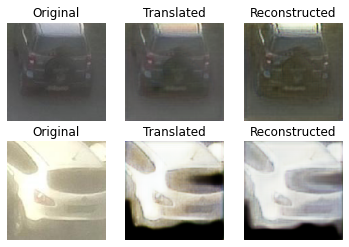

Epoch: 31 Batch: 121
(8, 128, 128, 3)
fake success
da_loss:  [0.14401891 0.78979492]
d_loss:  [0.08307892 0.89428711]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 19 s g_loss: [5.880299091339111, 0.7358615398406982, 1.020180583000183, 0.10752233862876892, 0.12101906538009644, 0.09267712384462357, 0.11163875460624695] 
Epoch: 31 Batch: 122
(8, 128, 128, 3)
fake success
da_loss:  [0.12669146 0.83300781]
d_loss:  [0.08772862 0.90808105]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 19 s g_loss: [5.425233364105225, 0.8406226634979248, 0.8538243174552917, 0.11319022625684738, 0.0954832136631012, 0.10347559303045273, 0.07919687032699585] 
Epoch: 32 / 200
Epoch: 32 Batch: 0
(8, 128, 128, 3)
fake success
da_loss:  [0.04605686 0.98803711]
d_loss:  [0.07504267 0.93017578]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 19 s g_loss: [5.820956707000732, 0.9428362846374512, 1.02809309959

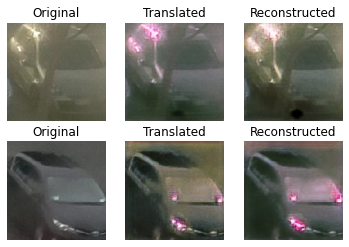

Epoch: 32 Batch: 1
(8, 128, 128, 3)
fake success
da_loss:  [0.04125019 0.98046875]
d_loss:  [0.045792   0.97180176]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 20 s g_loss: [7.305192470550537, 0.890012264251709, 0.9367269277572632, 0.15603065490722656, 0.1529761254787445, 0.12749651074409485, 0.1378796398639679] 
Epoch: 32 Batch: 2
(8, 128, 128, 3)
fake success
da_loss:  [0.0538574 0.9543457]
d_loss:  [0.04132054 0.96826172]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 21 s g_loss: [6.051641464233398, 0.9636279344558716, 0.9562904834747314, 0.11659853905439377, 0.11308278888463974, 0.10623941570520401, 0.09763942658901215] 
Epoch: 32 Batch: 3
(8, 128, 128, 3)
fake success
da_loss:  [0.09069785 0.90869141]
d_loss:  [0.06370965 0.94995117]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 21 s g_loss: [5.708644866943359, 0.8923537731170654, 0.9127607345581055, 0.11367763578891

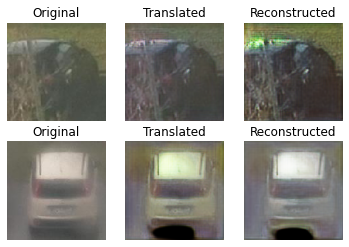

Epoch: 32 Batch: 11
(8, 128, 128, 3)
fake success
da_loss:  [0.0557671  0.98510742]
d_loss:  [0.05661928 0.96276855]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 25 s g_loss: [6.552933216094971, 1.1265523433685303, 0.9018155932426453, 0.1326255351305008, 0.12326429784297943, 0.12278249114751816, 0.09562492370605469] 
Epoch: 32 Batch: 12
(8, 128, 128, 3)
fake success
da_loss:  [0.12096819 0.85229492]
d_loss:  [0.08051105 0.92285156]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 25 s g_loss: [5.3546247482299805, 0.7221862077713013, 0.9209437370300293, 0.09627829492092133, 0.11369377374649048, 0.09149657189846039, 0.08758944272994995] 
Epoch: 32 Batch: 13
(8, 128, 128, 3)
fake success
da_loss:  [0.12582543 0.84960938]
d_loss:  [0.11820322 0.8737793 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 26 s g_loss: [5.368955612182617, 0.8273636102676392, 0.8706810474395752, 0.121455

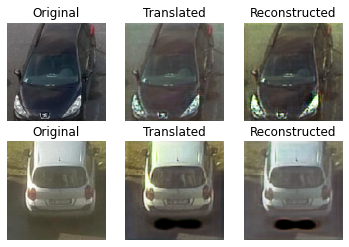

Epoch: 32 Batch: 21
(8, 128, 128, 3)
fake success
da_loss:  [0.06958219 0.92529297]
d_loss:  [0.0685355  0.93322754]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 29 s g_loss: [5.719355583190918, 0.9538605809211731, 0.9574775695800781, 0.12135465443134308, 0.09413187205791473, 0.10691608488559723, 0.07676751911640167] 
Epoch: 32 Batch: 22
(8, 128, 128, 3)
fake success
da_loss:  [0.0977977  0.89477539]
d_loss:  [0.08713704 0.9197998 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 30 s g_loss: [6.440410614013672, 0.8343900442123413, 0.9692019820213318, 0.11949820071458817, 0.1379963606595993, 0.10642125457525253, 0.12267573177814484] 
Epoch: 32 Batch: 23
(8, 128, 128, 3)
fake success
da_loss:  [0.05134231 0.98828125]
d_loss:  [0.06258523 0.97436523]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 30 s g_loss: [6.199807167053223, 1.003340482711792, 1.0219844579696655, 0.12471250

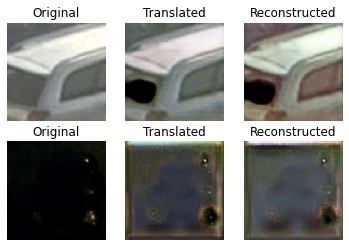

Epoch: 32 Batch: 31
(8, 128, 128, 3)
fake success
da_loss:  [0.14067232 0.86108398]
d_loss:  [0.10384339 0.90100098]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 33 s g_loss: [6.173540115356445, 1.0113509893417358, 0.8812441825866699, 0.12402288615703583, 0.11953859776258469, 0.10275460034608841, 0.1022820770740509] 
Epoch: 32 Batch: 32
(8, 128, 128, 3)
fake success
da_loss:  [0.40856796 0.6394043 ]
d_loss:  [0.24166743 0.78222656]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 34 s g_loss: [6.033074378967285, 0.9042452573776245, 0.9217813014984131, 0.1272978037595749, 0.10475731641054153, 0.11886762082576752, 0.09074312448501587] 
Epoch: 32 Batch: 33
(8, 128, 128, 3)
fake success
da_loss:  [0.17504808 0.80932617]
d_loss:  [0.10781938 0.89245605]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 34 s g_loss: [6.608543872833252, 1.067570686340332, 0.9439740777015686, 0.138114929

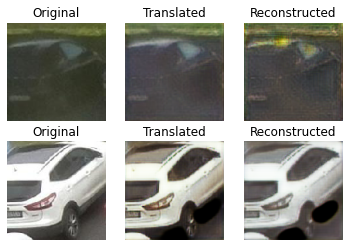

Epoch: 32 Batch: 41
(8, 128, 128, 3)
fake success
da_loss:  [0.10383256 0.87133789]
d_loss:  [0.06873972 0.93371582]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 37 s g_loss: [5.895188331604004, 0.7939993739128113, 1.0180304050445557, 0.08756102621555328, 0.14242856204509735, 0.07644406706094742, 0.12169617414474487] 
Epoch: 32 Batch: 42
(8, 128, 128, 3)
fake success
da_loss:  [0.12878289 0.8190918 ]
d_loss:  [0.08639064 0.89074707]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 38 s g_loss: [5.4821553230285645, 0.7340443134307861, 0.978198766708374, 0.11243078112602234, 0.09960485994815826, 0.10069624334573746, 0.08258770406246185] 
Epoch: 32 Batch: 43
(8, 128, 128, 3)
fake success
da_loss:  [0.06498345 0.94775391]
d_loss:  [0.05703317 0.96813965]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 38 s g_loss: [6.798671245574951, 0.8668868541717529, 1.0565135478973389, 0.121864

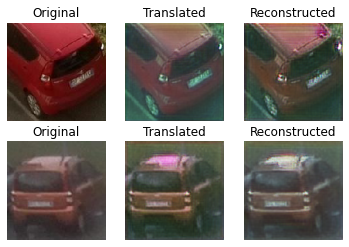

Epoch: 32 Batch: 51
(8, 128, 128, 3)
fake success
da_loss:  [0.07875222 0.92114258]
d_loss:  [0.05670318 0.95983887]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 42 s g_loss: [6.151539325714111, 1.0181388854980469, 0.9769552946090698, 0.11303688585758209, 0.11670776456594467, 0.11014629155397415, 0.09640910476446152] 
Epoch: 32 Batch: 52
(8, 128, 128, 3)
fake success
da_loss:  [0.08023894 0.9284668 ]
d_loss:  [0.09555422 0.89587402]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 42 s g_loss: [5.903388977050781, 0.8636490106582642, 0.8661931157112122, 0.13270753622055054, 0.08817894011735916, 0.132102832198143, 0.08619517087936401] 
Epoch: 32 Batch: 53
(8, 128, 128, 3)
fake success
da_loss:  [0.07263679 0.93652344]
d_loss:  [0.06618192 0.9473877 ]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 42 s g_loss: [7.657478332519531, 0.9199002385139465, 0.8729921579360962, 0.14792391

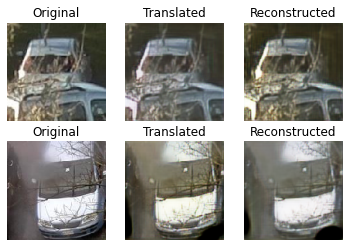

Epoch: 32 Batch: 61
(8, 128, 128, 3)
fake success
da_loss:  [0.0873114  0.92602539]
d_loss:  [0.06156412 0.95825195]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 46 s g_loss: [6.464971542358398, 0.8599128127098083, 0.979290246963501, 0.13795635104179382, 0.1273459494113922, 0.11552374809980392, 0.10367020964622498] 
Epoch: 32 Batch: 62
(8, 128, 128, 3)
fake success
da_loss:  [0.11311336 0.85473633]
d_loss:  [0.0771149  0.91113281]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 46 s g_loss: [7.186592102050781, 0.772079348564148, 1.0468254089355469, 0.13104461133480072, 0.17208755016326904, 0.10990142077207565, 0.14969474077224731] 
Epoch: 32 Batch: 63
(8, 128, 128, 3)
fake success
da_loss:  [0.14961511 0.75634766]
d_loss:  [0.11538921 0.83837891]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 47 s g_loss: [5.866260528564453, 0.8015525937080383, 0.959684431552887, 0.1209813207

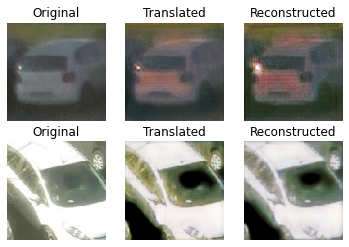

Epoch: 32 Batch: 71
(8, 128, 128, 3)
fake success
da_loss:  [0.04343837 0.99047852]
d_loss:  [0.03193669 0.99304199]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 50 s g_loss: [6.568110942840576, 1.0485081672668457, 1.0140552520751953, 0.11930105090141296, 0.12645679712295532, 0.10743247717618942, 0.12011963129043579] 
Epoch: 32 Batch: 72
(8, 128, 128, 3)
fake success
da_loss:  [0.12184564 0.85400391]
d_loss:  [0.07814112 0.91992188]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 50 s g_loss: [6.546108722686768, 0.8607273697853088, 0.9587110280990601, 0.12215762585401535, 0.14018061757087708, 0.1126534640789032, 0.12104517966508865] 
Epoch: 32 Batch: 73
(8, 128, 128, 3)
fake success
da_loss:  [0.11023301 0.88012695]
d_loss:  [0.08308665 0.91821289]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 51 s g_loss: [5.948918342590332, 0.8392996788024902, 0.8327620029449463, 0.1327891

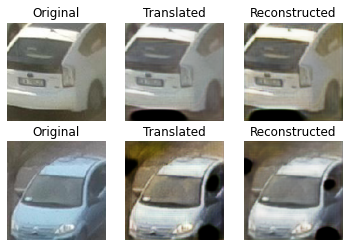

Epoch: 32 Batch: 81
(8, 128, 128, 3)
fake success
da_loss:  [0.11186498 0.87133789]
d_loss:  [0.08582423 0.91320801]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 54 s g_loss: [6.2875871658325195, 0.7765471935272217, 0.9163512587547302, 0.11665508896112442, 0.1333998590707779, 0.11414051800966263, 0.11854162812232971] 
Epoch: 32 Batch: 82
(8, 128, 128, 3)
fake success
da_loss:  [0.08105312 0.90258789]
d_loss:  [0.0632671  0.93249512]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 55 s g_loss: [6.652395248413086, 0.8414124250411987, 0.9140413999557495, 0.13261792063713074, 0.13153690099716187, 0.13485321402549744, 0.11574601382017136] 
Epoch: 32 Batch: 83
(8, 128, 128, 3)
fake success
da_loss:  [0.0532951  0.96313477]
d_loss:  [0.05727141 0.94836426]
imgs_A: (8, 128, 128, 3), imgB: (8, 128, 128, 3)
valid:(8, 16, 16, 1)
time: 29 mins 55 s g_loss: [5.913954734802246, 0.8754934668540955, 0.8988953232765198, 0.124619

In [0]:
# Main Part
if __name__ == '__main__':
    # batch_size not suggest more than 8 because the memory is not enough
    train(epochs=200, batch_size=8, sample_interval=10)

# An example with Imperement cycle gan

In [0]:
!pip install git+https://www.github.com/farizrahman4u/keras-contrib.git

  Cloning https://www.github.com/farizrahman4u/keras-contrib.git to /tmp/pip-req-build-kjo13582
  Running command git clone -q https://www.github.com/farizrahman4u/keras-contrib.git /tmp/pip-req-build-kjo13582
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=7037ed843a66369a7104b5f9f5f7cd62de3581f7f3f50ccfb655466f3b3c9460
  Stored in directory: /tmp/pip-ephem-wheel-cache-234i_s_4/wheels/1f/8e/ac/fb1cca9d92276d64365b204e82a9a5bec1f24a20aca28fdbec
Successfully built keras-contrib


Loaded (1000, 128, 128, 3) (1000, 128, 128, 3)


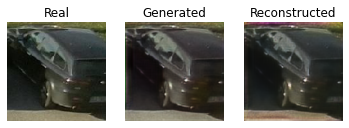

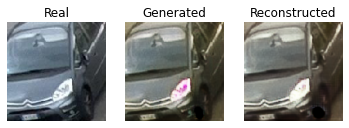

In [0]:
import tensorflow_addons as tfa
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot as plt
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
#from tensorflow_addons.layers import InstanceNormalization
import cv2

# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = X1 / 127.5 - 1.
    X2 = X2 / 127.5 - 1.
    return [X1, X2]

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        plt.subplot(1, len(images), 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(images[i])
        # title
        plt.title(titles[i])
    plt.show()

# Load Cycle GAN model
cust = {'InstanceNormalization': InstanceNormalization}
model_AB = load_model('/content/gdrive/FYP/workGanOutput/python/t14/gen_model/g_model_AB_48_50.h5', cust)
model_BA = load_model('/content/gdrive/FYP/workGanOutput/python/t14/gen_model/g_model_BA_48_50.h5', cust)

# load dataset
root_d = '/content/gdrive/FYP/cycle_gan_val.npz' # follow the path of before step
A_data, B_data = load_real_samples(root_d)
print('Loaded', A_data.shape, B_data.shape)

# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AB.predict(A_real)
A_reconstructed = model_BA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BA.predict(B_real)
B_reconstructed = model_AB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)